# Digit Recognition with Deep Learning: A MNIST Approach using PyTorch

by Jason Jiang

This project will use the well-known MNIST dataset containing handwritten digits from 0-9. The dataset is collected and used from the PyTorch library.

Also, we'll attempt to use and create two simple types of models to recognise these digits and compare their performances.

1. MLP (Multilayer Perceptron)
2. CNN (Convolutional Neural Network)

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
import random
import matplotlib.pyplot as plt

C:\Users\nosaJ\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 200

# Transformation include resizing, converting to Tensor(which is necessary for PyTorch), and normalisation using common values for mean and standard deviation
transform = transforms.Compose([
            transforms.Resize(40),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

full_dataset = MNIST(root='.', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size) 
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [3]:
print("Training Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Testing Dataset Size:", len(test_dataset))
print("Training DataLoader Size:", len(train_loader))
print("Validation DataLoader Size:", len(val_loader))
print("Testing DataLoader Size:", len(test_loader))

Training Dataset Size: 48000
Validation Dataset Size: 12000
Testing Dataset Size: 10000
Training DataLoader Size: 240
Validation DataLoader Size: 60
Testing DataLoader Size: 50


48000 training MNIST images and 10000 testing MNIST images.

300 total batches in training dataset each with 200 images. 50 total batches in testing dataset each with 200 images.

In [4]:
train_data_iter = iter(train_loader)
data, labels = train_data_iter.next()
print("Images Batch Data Shape", data.shape)
print("Labels Batch Data Shape", labels.shape)

Images Batch Data Shape torch.Size([200, 1, 40, 40])
Labels Batch Data Shape torch.Size([200])


As expected, first batch as 200 images.

Now visualising a whole batch of images along with their labels.

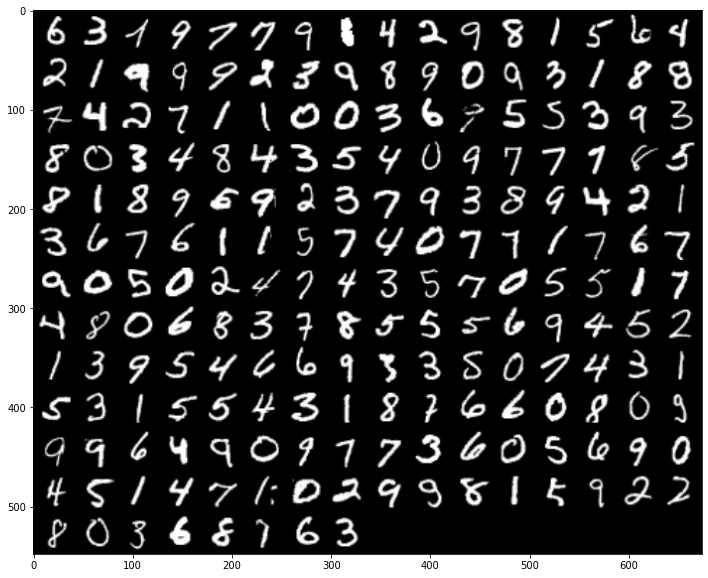

tensor([6, 3, 1, 9, 7, 7, 9, 1, 4, 2, 9, 8, 1, 5, 6, 4, 2, 1, 9, 9, 9, 2, 3, 9,
        8, 9, 0, 9, 3, 1, 8, 8, 7, 4, 2, 7, 1, 1, 0, 0, 3, 6, 9, 5, 5, 3, 9, 3,
        8, 0, 3, 4, 8, 4, 3, 5, 4, 0, 9, 7, 7, 7, 8, 5, 8, 1, 8, 9, 5, 9, 2, 3,
        7, 9, 3, 8, 9, 4, 2, 1, 3, 6, 7, 6, 1, 1, 5, 7, 4, 0, 7, 7, 1, 7, 6, 7,
        9, 0, 5, 0, 2, 4, 7, 4, 3, 5, 7, 0, 5, 5, 1, 7, 4, 8, 0, 6, 8, 3, 7, 8,
        5, 5, 5, 6, 9, 4, 5, 2, 1, 3, 9, 5, 4, 6, 6, 9, 3, 3, 5, 0, 7, 4, 3, 1,
        5, 3, 1, 5, 5, 4, 3, 1, 8, 7, 6, 6, 0, 8, 0, 9, 9, 9, 6, 4, 9, 0, 9, 7,
        7, 3, 6, 0, 5, 6, 9, 0, 4, 5, 1, 4, 7, 1, 0, 2, 9, 9, 8, 1, 5, 9, 2, 2,
        8, 0, 3, 6, 8, 7, 6, 3])


In [5]:
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data, nrow=16, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.show()
print(labels)

## Multilayer Perceptron (MLP)

In [6]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(40*40, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 40*40)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model_mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

# Lists to store training, validation, and testing accuracy and loss
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model_mlp.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_train_loss += loss.item()

    train_accuracy = correct_train / total_train
    train_loss = running_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validation loop
    model_mlp.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_mlp(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            running_val_loss += loss.item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / len(val_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training Finished!')
# Testing loop after training
model_mlp.eval()
correct_test = 0
total_test = 0
running_test_loss = 0.0
incorrect_pred = torch.tensor([]).to(torch.int)
incorrect_label = torch.tensor([]).to(torch.int)
incorrect_imgs = torch.tensor([])
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        incorrect_idxs = labels != predicted
        incorrect_pred = torch.cat([incorrect_pred, predicted[incorrect_idxs]], dim=0)
        incorrect_label = torch.cat([incorrect_label, labels[incorrect_idxs]], dim=0)
        incorrect_imgs = torch.cat([incorrect_imgs, inputs[incorrect_idxs]], dim=0)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        running_test_loss += loss.item()
test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)
print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.2647, Train Accuracy: 0.9197, Validation Loss: 0.1527, Validation Accuracy: 0.9533
Epoch 2/10, Train Loss: 0.0993, Train Accuracy: 0.9700, Validation Loss: 0.1062, Validation Accuracy: 0.9676
Epoch 3/10, Train Loss: 0.0679, Train Accuracy: 0.9785, Validation Loss: 0.0964, Validation Accuracy: 0.9697
Epoch 4/10, Train Loss: 0.0535, Train Accuracy: 0.9823, Validation Loss: 0.0936, Validation Accuracy: 0.9718
Epoch 5/10, Train Loss: 0.0390, Train Accuracy: 0.9870, Validation Loss: 0.0940, Validation Accuracy: 0.9742
Epoch 6/10, Train Loss: 0.0326, Train Accuracy: 0.9893, Validation Loss: 0.0920, Validation Accuracy: 0.9761
Epoch 7/10, Train Loss: 0.0308, Train Accuracy: 0.9899, Validation Loss: 0.1007, Validation Accuracy: 0.9739
Epoch 8/10, Train Loss: 0.0223, Train Accuracy: 0.9923, Validation Loss: 0.0886, Validation Accuracy: 0.9791
Epoch 9/10, Train Loss: 0.0211, Train Accuracy: 0.9930, Validation Loss: 0.1003, Validation Accuracy: 0.9763
Epoch 10/10, Train 

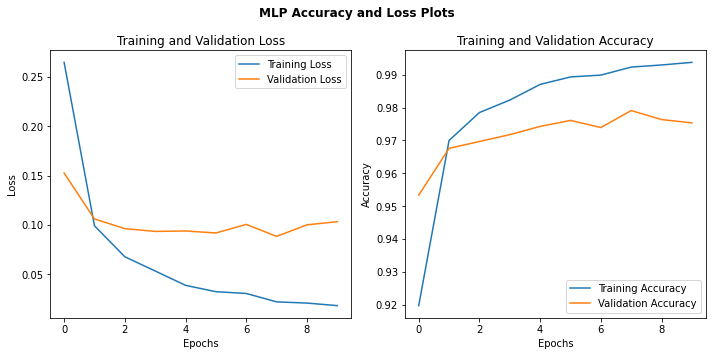

In [7]:
# Plotting the results
plt.figure(figsize=(10,5))
plt.suptitle('MLP Accuracy and Loss Plots', fontweight='bold')
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
print(f'The MLP model made a total of {len(incorrect_pred)} incorrect predictions!!')

The MLP model made a total of 202 incorrect predictions!!


We'll show 10 random incorrect predictions made by this MLP model.

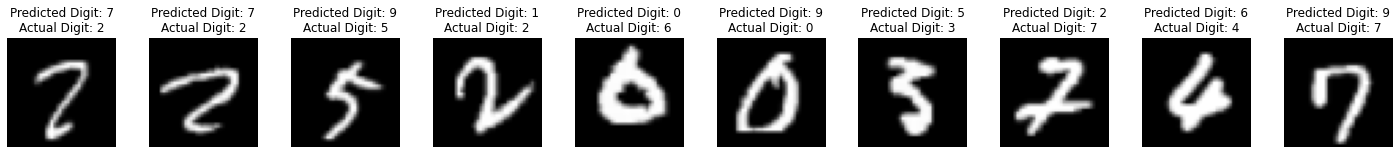

In [9]:
random_idxs = random.sample(range(0,len(incorrect_pred)), 10)
plt.figure(figsize=(25,2))
for i in range(len(random_idxs)):
    plt.subplot(1,10,i+1)
    plt.title(f"Predicted Digit: {incorrect_pred[random_idxs[i]]}\nActual Digit: {incorrect_label[random_idxs[i]]}")
    plt.axis('off')
    plt.imshow(incorrect_imgs[random_idxs[i]].numpy().transpose((1, 2, 0)),cmap='gray')

## Convolutional Neural Network (CNN)

In [10]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 10 * 10, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model_cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Lists to store training, validation, and testing accuracy and loss
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model_cnn.train()
    correct_train = 0
    total_train = 0
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_train_loss += loss.item()

    train_accuracy = correct_train / total_train
    train_loss = running_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validation loop
    model_cnn.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_cnn(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            running_val_loss += loss.item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / len(val_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training Finished!')
# Testing loop after training
model_cnn.eval()
correct_test = 0
total_test = 0
running_test_loss = 0.0
incorrect_pred = torch.tensor([]).to(torch.int)
incorrect_label = torch.tensor([]).to(torch.int)
incorrect_imgs = torch.tensor([])
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        incorrect_idxs = labels != predicted
        incorrect_pred = torch.cat([incorrect_pred, predicted[incorrect_idxs]], dim=0)
        incorrect_label = torch.cat([incorrect_label, labels[incorrect_idxs]], dim=0)
        incorrect_imgs = torch.cat([incorrect_imgs, inputs[incorrect_idxs]], dim=0)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        running_test_loss += loss.item()
test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)
print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.2214, Train Accuracy: 0.9328, Validation Loss: 0.0798, Validation Accuracy: 0.9764
Epoch 2/10, Train Loss: 0.0568, Train Accuracy: 0.9828, Validation Loss: 0.0526, Validation Accuracy: 0.9847
Epoch 3/10, Train Loss: 0.0366, Train Accuracy: 0.9891, Validation Loss: 0.0491, Validation Accuracy: 0.9841
Epoch 4/10, Train Loss: 0.0278, Train Accuracy: 0.9908, Validation Loss: 0.0476, Validation Accuracy: 0.9857
Epoch 5/10, Train Loss: 0.0191, Train Accuracy: 0.9941, Validation Loss: 0.0483, Validation Accuracy: 0.9848
Epoch 6/10, Train Loss: 0.0140, Train Accuracy: 0.9956, Validation Loss: 0.0492, Validation Accuracy: 0.9862
Epoch 7/10, Train Loss: 0.0117, Train Accuracy: 0.9964, Validation Loss: 0.0480, Validation Accuracy: 0.9857
Epoch 8/10, Train Loss: 0.0096, Train Accuracy: 0.9968, Validation Loss: 0.0580, Validation Accuracy: 0.9852
Epoch 9/10, Train Loss: 0.0073, Train Accuracy: 0.9977, Validation Loss: 0.0572, Validation Accuracy: 0.9860
Epoch 10/10, Train 

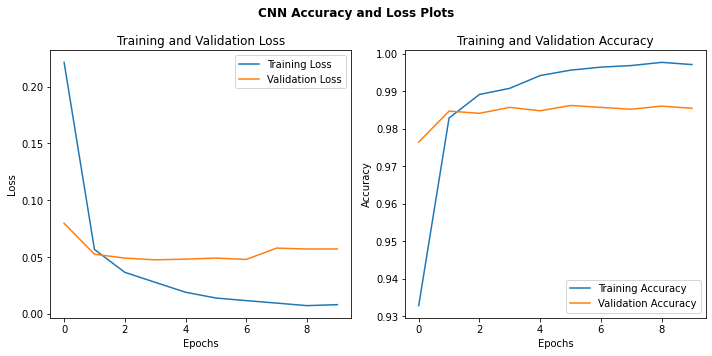

In [11]:
# Plotting the results
plt.figure(figsize=(10,5))
plt.suptitle('CNN Accuracy and Loss Plots', fontweight='bold')
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print(f'The CNN model made a total of {len(incorrect_pred)} incorrect predictions!!')

The CNN model made a total of 112 incorrect predictions!!


We'll show 10 random incorrect predictions made by this CNN model.

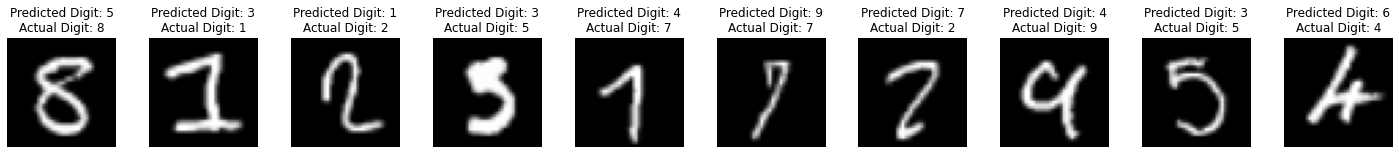

In [13]:
random_idxs = random.sample(range(0,len(incorrect_pred)), 10)
plt.figure(figsize=(25,2))
for i in range(len(random_idxs)):
    plt.subplot(1,10,i+1)
    plt.title(f"Predicted Digit: {incorrect_pred[random_idxs[i]]}\nActual Digit: {incorrect_label[random_idxs[i]]}")
    plt.axis('off')
    plt.imshow(incorrect_imgs[random_idxs[i]].numpy().transpose((1, 2, 0)),cmap='gray')

## Conclusion

- Both models are able to produce very good testing results, with accuracy values of 0.9798 and 0.9888 for MLP and CNN, respectively.

- Despite these exceptional results from both models, the MLP model made more incorrect predictions than the CNN model. This was the expected conclusion.

- CNNs tend to perform better on image datasets than MLPs, like the MNIST dataset. This is due to a number of reasons:

    1. CNNs are designed to capture spatial relationships and patterns, unlike MLPs.
    2. Specifically for images, CNNs consider pixels and the spatial arrangement around them, therefore getting more information about patterns in images. MLPs, however, look at each pixel individually and not the spatial arrangement around it.

